<a href="https://colab.research.google.com/github/lqiang67/generative_models_examples/blob/main/GAN_2D_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

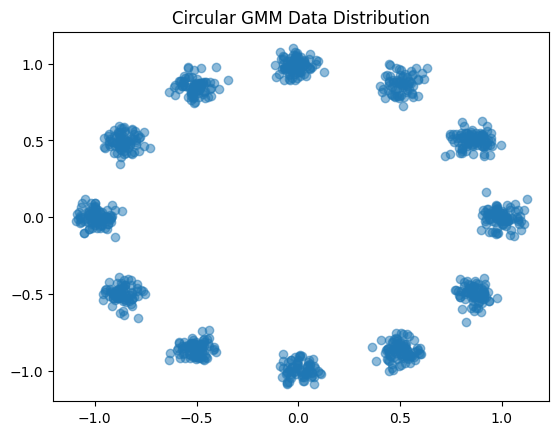

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def sample_circular_gmm(batch_size, num_modes=4, radius=1.0, std=.05):
    angles = np.linspace(0, 2 * np.pi, num_modes, endpoint=False)
    centers = np.array([[radius * np.cos(angle), radius * np.sin(angle)] for angle in angles])

    batch_data = []
    for i in range(batch_size):
        center = centers[np.random.choice(len(centers))]
        point = center + np.random.normal(0, std, size=center.shape)
        batch_data.append(point)

    return torch.tensor(batch_data, dtype=torch.float32)

# Visualize the data
data_points = sample_circular_gmm(1000, num_modes=12)
plt.scatter(data_points[:, 0], data_points[:, 1], alpha=0.5)
plt.title('Circular GMM Data Distribution')
plt.show()


In [86]:
def plot_contour_2d(discriminator, xlim=(-2, 2), ylim=(-2, 2), num_points=100):
    x = np.linspace(xlim[0], xlim[1], num_points)
    y = np.linspace(ylim[0], ylim[1], num_points)
    X, Y = np.meshgrid(x, y)

    # Flatten the grid to pass through the discriminator
    coords = np.vstack([X.ravel(), Y.ravel()]).T
    coords_torch = torch.tensor(coords, dtype=torch.float32)

    # Disable gradient computation for efficiency
    with torch.no_grad():
        Z = discriminator(coords_torch).numpy().reshape(X.shape)

    plt.contour(X, Y, Z, levels=20, cmap='viridis')



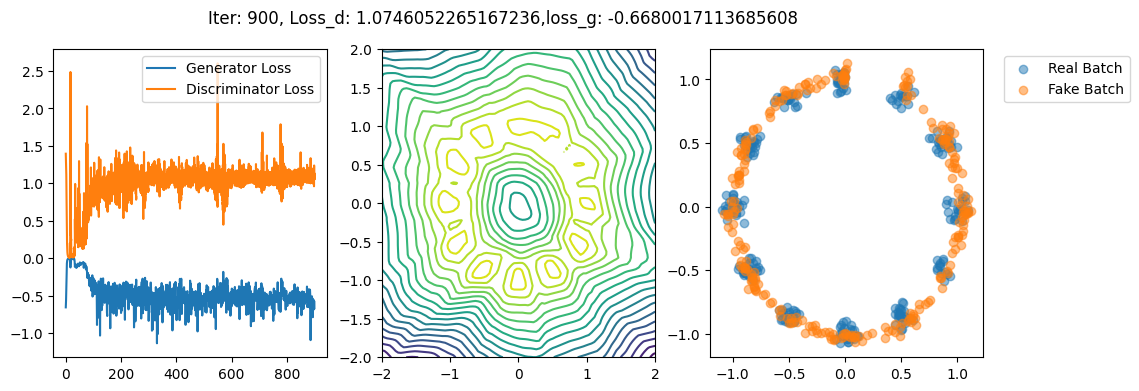

In [99]:
#@title Training GAN
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# a general MLP which can use customed linear layers and activation functions.
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation=nn.LeakyReLU, linear_layer=nn.Linear):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        self.linear_layer = linear_layer
        for i in range(len(layer_sizes) - 1):
            self.layers.append(self.linear_layer(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:  # No activation after the last layer
                self.layers.append(self.activation())

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x

noise_dim = 10
data_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = MLP([noise_dim, 128, 128, 128, 128,128, 128, data_dim]).to(device)
generator.get_noise = lambda batch_size: torch.randn(batch_size, noise_dim).to(device)
discriminator = MLP([data_dim, 128,128, 128, 1]).to(device)


optimizer_g = optim.Adam(generator.parameters(), lr=0.0005, betas = (0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0005, betas= (0.5, 0.999))
#optimizer_g = optim.SGD(generator.parameters(), lr=0.005)
#optimizer_d = optim.SGD(discriminator.parameters(), lr=0.05)

batch_size = 256

loss_g_curve = []
loss_d_curve = []
criterion = nn.BCEWithLogitsLoss()
generator_inner_step = 1
discriminator_inner_step = 10
for iter in range(1000):

    # discriminator update
    for i in range(discriminator_inner_step):
        optimizer_d.zero_grad()

        # data
        real_batch = data_points[torch.randperm(data_points.shape[0])[:batch_size]].to(device)
        fake_batch = generator(generator.get_noise(batch_size)).detach()

        # loss
        real_loss = criterion(discriminator(real_batch), torch.ones(batch_size,1))
        fake_loss = criterion(discriminator(fake_batch), torch.zeros(batch_size,1))
        loss_d = real_loss + fake_loss
        loss_d.backward()
        optimizer_d.step()

        loss_d_curve.append(loss_d.item())

    # generator update
    for i in range(generator_inner_step):
        optimizer_g.zero_grad()

        # data
        fake_batch = generator(generator.get_noise(batch_size))

        # loss
        #loss_g = criterion(discriminator(fake_batch), torch.ones(batch_size,1))
        loss_g = -criterion(discriminator(fake_batch), torch.zeros(batch_size,1))
        loss_g.backward()
        optimizer_g.step()

        loss_g_curve.append(loss_g.item())

    # plot
    if iter % 100 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(4*3,4))

        plt.subplot(1, 3, 1)
        plt.plot(torch.linspace(0, iter, len(loss_g_curve)), loss_g_curve, label='Generator Loss')
        plt.plot(torch.linspace(0, iter, len(loss_d_curve)), loss_d_curve, label='Discriminator Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plot_contour_2d(discriminator)

        plt.subplot(1, 3, 3)
        plt.scatter(real_batch[:, 0], real_batch[:, 1], alpha=0.5, label='Real Batch')
        plt.scatter(fake_batch[:, 0].detach().cpu().numpy(), fake_batch[:, 1].detach().cpu().numpy(), alpha=0.5, label='Fake Batch')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.suptitle(f'Iter: {iter}, Loss_d: {loss_d.item()},loss_g: {loss_g.item()}')
        plt.show()
